In [12]:
pip install stable_baselines3 shimmy

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1360 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 996        |
|    iterations           | 2          |
|    time_elapsed         | 4          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00750212 |
|    clip_fraction        | 0.0751     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.84      |
|    explained_variance   | -0.00667   |
|    learning_rate        | 0.0003     |
|    loss                 | 2.94e+04   |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00729   |
|    std                  | 1          |
|    value_loss           | 6.74e+04   |
-----------------------------------

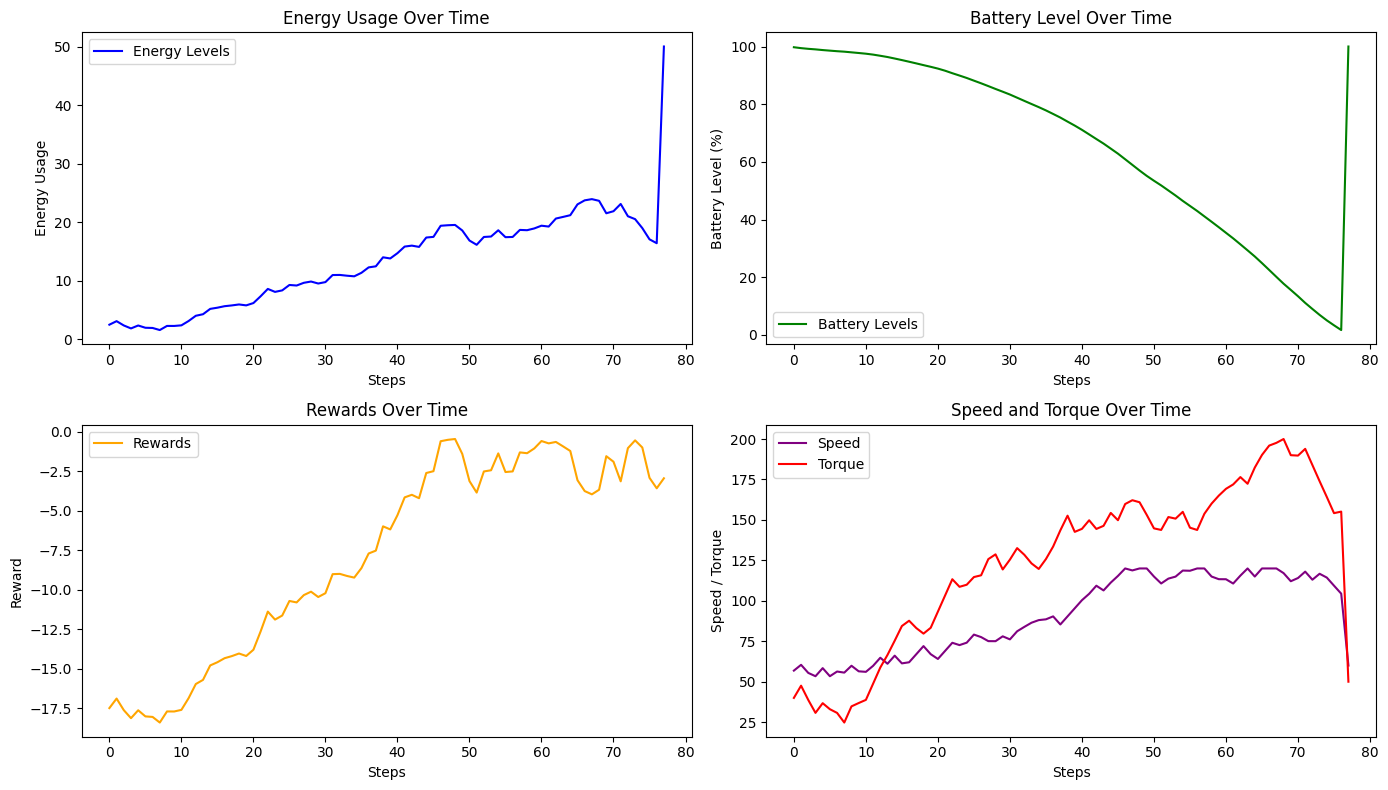

In [19]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Custom Environment for Motor Optimization
class MotorOptimizationEnvWithBattery(gym.Env):
    def __init__(self):  # Correct the typo: __init__ instead of _init_
        super(MotorOptimizationEnvWithBattery, self).__init__()

        # Action space: Adjust torque and speed
        self.action_space = gym.spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)

        # Observation space: [energy usage, speed, torque, temperature, battery level]
        self.observation_space = gym.spaces.Box(
            low=np.array([0, 0, 0, 0, 0]),  # Minimum values
            high=np.array([100, 120, 200, 100, 100]),  # Maximum values
            dtype=np.float32,
        )

        # Initial state
        self.state = np.array([50.0, 60.0, 50.0, 25.0, 100.0])  # [energy, speed, torque, temperature, battery level]
        self.steps = 0
        self.max_steps = 200

    def reset(self):
        """Reset the environment."""
        self.state = np.array([50.0, 60.0, 50.0, 25.0, 100.0])  # Reset battery to full
        self.steps = 0
        return self.state

    def step(self, action):
        """Simulate a step in the environment."""
        self.steps += 1

        # Unpack state variables
        energy, speed, torque, temperature, battery = self.state

        # Adjust speed and torque based on actions
        speed += action[0] * 5  # Adjust speed
        torque += action[1] * 10  # Adjust torque

        # Clip speed and torque to their valid ranges
        speed = np.clip(speed, 0, 120)
        torque = np.clip(torque, 0, 200)

        # Calculate energy consumption based on speed and torque
        energy_consumption = (speed * torque / 1000) + (temperature / 100)
        energy = np.clip(energy_consumption, 0, 100)  # Update energy readings

        # Update battery level (battery decreases based on energy consumption)
        battery -= energy_consumption * 0.1  # Battery usage factor
        battery = np.clip(battery, 0, 100)  # Ensure battery doesn't go below 0

        # Calculate reward
        optimal_consumption = 20  # Define an optimal energy consumption threshold
        efficiency_penalty = abs(energy_consumption - optimal_consumption)  # Penalize deviations
        reward = -efficiency_penalty

        # Update state
        temperature += np.random.uniform(-0.5, 0.5)  # Simulate temperature fluctuation
        self.state = np.array([energy, speed, torque, temperature, battery])

        # Check if the episode is done
        done = self.steps >= self.max_steps or battery <= 0

        return self.state, reward, done, {}

    def render(self, mode="human"):
        """Render the environment."""
        print(f"State: {self.state}")



# Create and wrap the environment
env = DummyVecEnv([lambda: MotorOptimizationEnvWithBattery()])

# Initialize PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the PPO model
model.learn(total_timesteps=10000)

# Function to simulate the trained
# Function to simulate the trained policy
def simulate_motor_optimization(model, env, steps=200):
    state = env.reset()
    energy_levels = []
    battery_levels = []
    rewards = []
    speeds = []
    torques = []

    for _ in range(steps):
        # Predict action using the trained policy
        action, _ = model.predict(state)
        state, reward, done, _ = env.step(action)

        # Collect metrics for plotting
        energy_levels.append(state[0][0])  # Energy level
        battery_levels.append(state[0][4])  # Battery level
        rewards.append(reward)            # Reward
        speeds.append(state[0][1])        # Speed
        torques.append(state[0][2])       # Torque

        if done:
            break

    return energy_levels, battery_levels, rewards, speeds, torques

# Simulate the trained model
energy_levels, battery_levels, rewards, speeds, torques = simulate_motor_optimization(model, env)

# Visualization
plt.figure(figsize=(14, 8))

# Energy Levels
plt.subplot(2, 2, 1)
plt.plot(energy_levels, label="Energy Levels", color="blue")
plt.xlabel("Steps")
plt.ylabel("Energy Usage")
plt.title("Energy Usage Over Time")
plt.legend()

# Battery Levels
plt.subplot(2, 2, 2)
plt.plot(battery_levels, label="Battery Levels", color="green")
plt.xlabel("Steps")
plt.ylabel("Battery Level (%)")
plt.title("Battery Level Over Time")
plt.legend()

# Rewards
plt.subplot(2, 2, 3)
plt.plot(rewards, label="Rewards", color="orange")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Rewards Over Time")
plt.legend()

# Speeds and Torques
plt.subplot(2, 2, 4)
plt.plot(speeds, label="Speed", color="purple")
plt.plot(torques, label="Torque", color="red")
plt.xlabel("Steps")
plt.ylabel("Speed / Torque")
plt.title("Speed and Torque Over Time")
plt.legend()

plt.tight_layout()
plt.show()

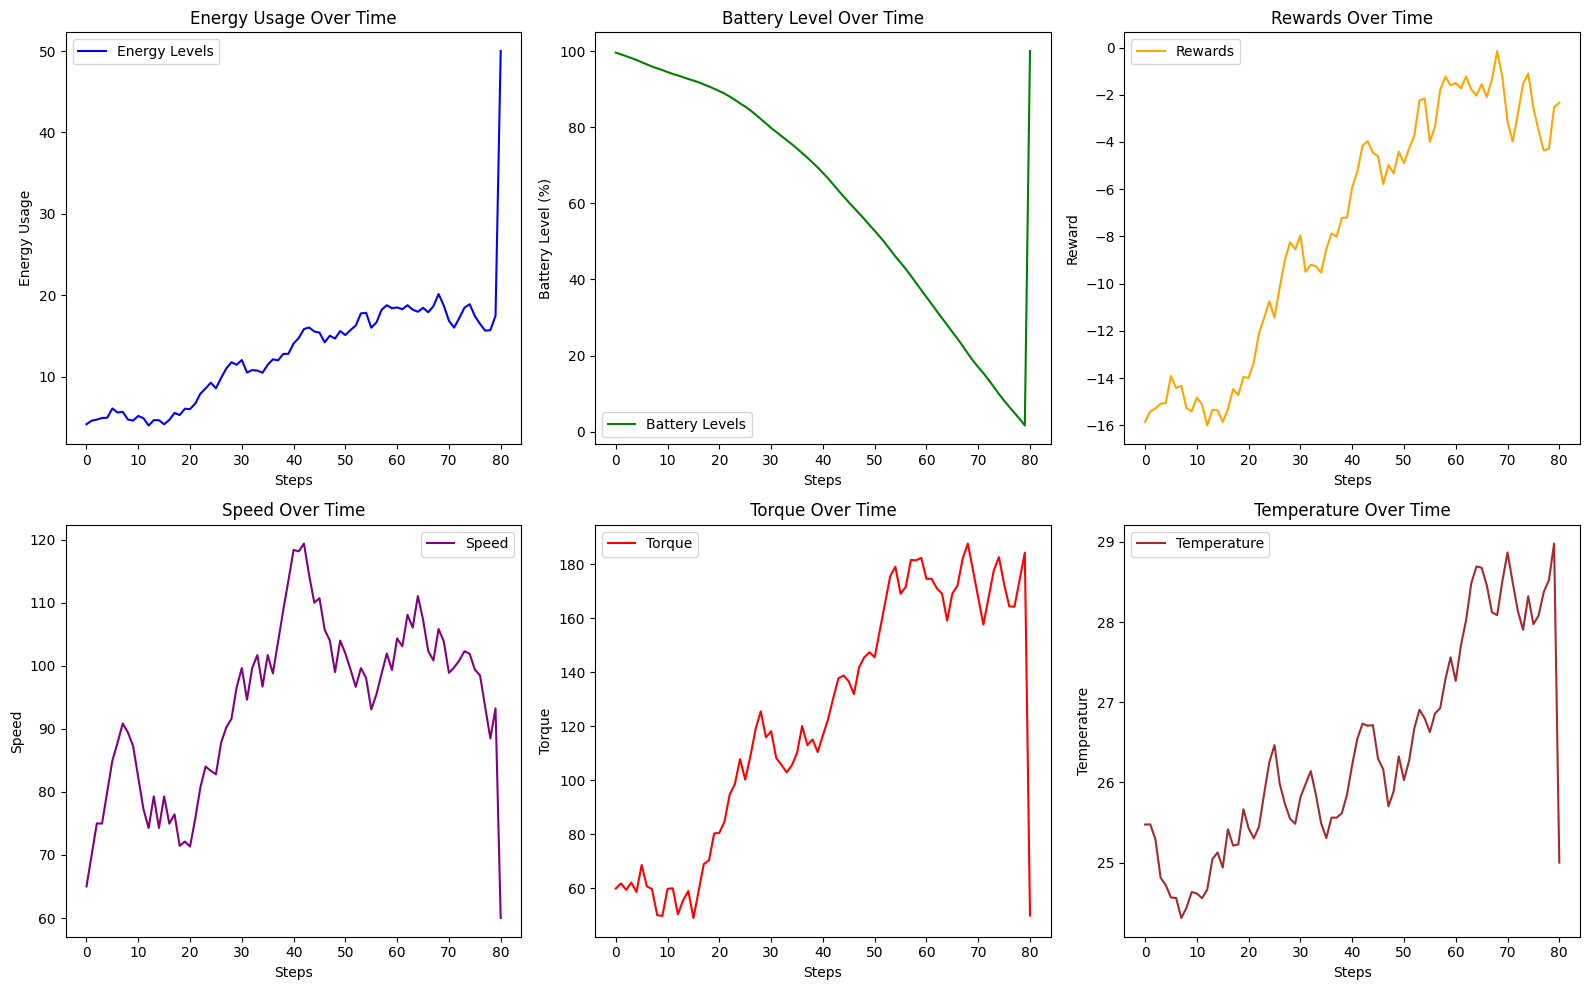


Simulation Data Log:
{'Step': 1, 'Energy': 4.15, 'Battery': 99.585, 'Speed': 65.0, 'Torque': 60.0, 'Temperature': 25.474707, 'Reward': array([-15.85], dtype=float32)}
{'Step': 2, 'Energy': 4.5861964, 'Battery': 99.12638, 'Speed': 70.0, 'Torque': 61.877846, 'Temperature': 25.477715, 'Reward': array([-15.413804], dtype=float32)}
{'Step': 3, 'Energy': 4.716915, 'Battery': 98.654686, 'Speed': 75.0, 'Torque': 59.49517, 'Temperature': 25.291136, 'Reward': array([-15.283085], dtype=float32)}
{'Step': 4, 'Energy': 4.9157763, 'Battery': 98.16311, 'Speed': 74.968475, 'Torque': 62.197678, 'Temperature': 24.811678, 'Reward': array([-15.084224], dtype=float32)}
{'Step': 5, 'Energy': 4.9438863, 'Battery': 97.668724, 'Speed': 79.968475, 'Torque': 58.720257, 'Temperature': 24.719648, 'Reward': array([-15.056113], dtype=float32)}
{'Step': 6, 'Energy': 6.086252, 'Battery': 97.0601, 'Speed': 84.968475, 'Torque': 68.72026, 'Temperature': 24.564716, 'Reward': array([-13.913748], dtype=float32)}
{'Step': 7

In [20]:
# Function to simulate the trained policy and log data
def simulate_motor_optimization_with_logs(model, env, steps=200):
    state = env.reset()
    energy_levels = []
    battery_levels = []
    rewards = []
    speeds = []
    torques = []
    temperatures = []
    log_data = []

    for step in range(steps):
        # Predict action using the trained policy
        action, _ = model.predict(state)
        state, reward, done, _ = env.step(action)

        # Collect metrics for plotting
        energy_levels.append(state[0][0])    # Energy level
        battery_levels.append(state[0][4])  # Battery level
        rewards.append(reward)              # Reward
        speeds.append(state[0][1])          # Speed
        torques.append(state[0][2])         # Torque
        temperatures.append(state[0][3])    # Temperature

        # Log data for this step
        log_data.append({
            "Step": step + 1,
            "Energy": state[0][0],
            "Battery": state[0][4],
            "Speed": state[0][1],
            "Torque": state[0][2],
            "Temperature": state[0][3],
            "Reward": reward
        })

        if done:
            break

    return energy_levels, battery_levels, rewards, speeds, torques, temperatures, log_data

# Simulate the trained model and collect logs
energy_levels, battery_levels, rewards, speeds, torques, temperatures, simulation_log = simulate_motor_optimization_with_logs(model, env)

# Visualization
plt.figure(figsize=(16, 10))

# Energy Levels
plt.subplot(2, 3, 1)
plt.plot(energy_levels, label="Energy Levels", color="blue")
plt.xlabel("Steps")
plt.ylabel("Energy Usage")
plt.title("Energy Usage Over Time")
plt.legend()

# Battery Levels
plt.subplot(2, 3, 2)
plt.plot(battery_levels, label="Battery Levels", color="green")
plt.xlabel("Steps")
plt.ylabel("Battery Level (%)")
plt.title("Battery Level Over Time")
plt.legend()

# Rewards
plt.subplot(2, 3, 3)
plt.plot(rewards, label="Rewards", color="orange")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Rewards Over Time")
plt.legend()

# Speeds
plt.subplot(2, 3, 4)
plt.plot(speeds, label="Speed", color="purple")
plt.xlabel("Steps")
plt.ylabel("Speed")
plt.title("Speed Over Time")
plt.legend()

# Torques
plt.subplot(2, 3, 5)
plt.plot(torques, label="Torque", color="red")
plt.xlabel("Steps")
plt.ylabel("Torque")
plt.title("Torque Over Time")
plt.legend()

# Temperatures
plt.subplot(2, 3, 6)
plt.plot(temperatures, label="Temperature", color="brown")
plt.xlabel("Steps")
plt.ylabel("Temperature")
plt.title("Temperature Over Time")
plt.legend()

plt.tight_layout()
plt.show()

# Print simulation log
print("\nSimulation Data Log:")
for entry in simulation_log:
    print(entry)


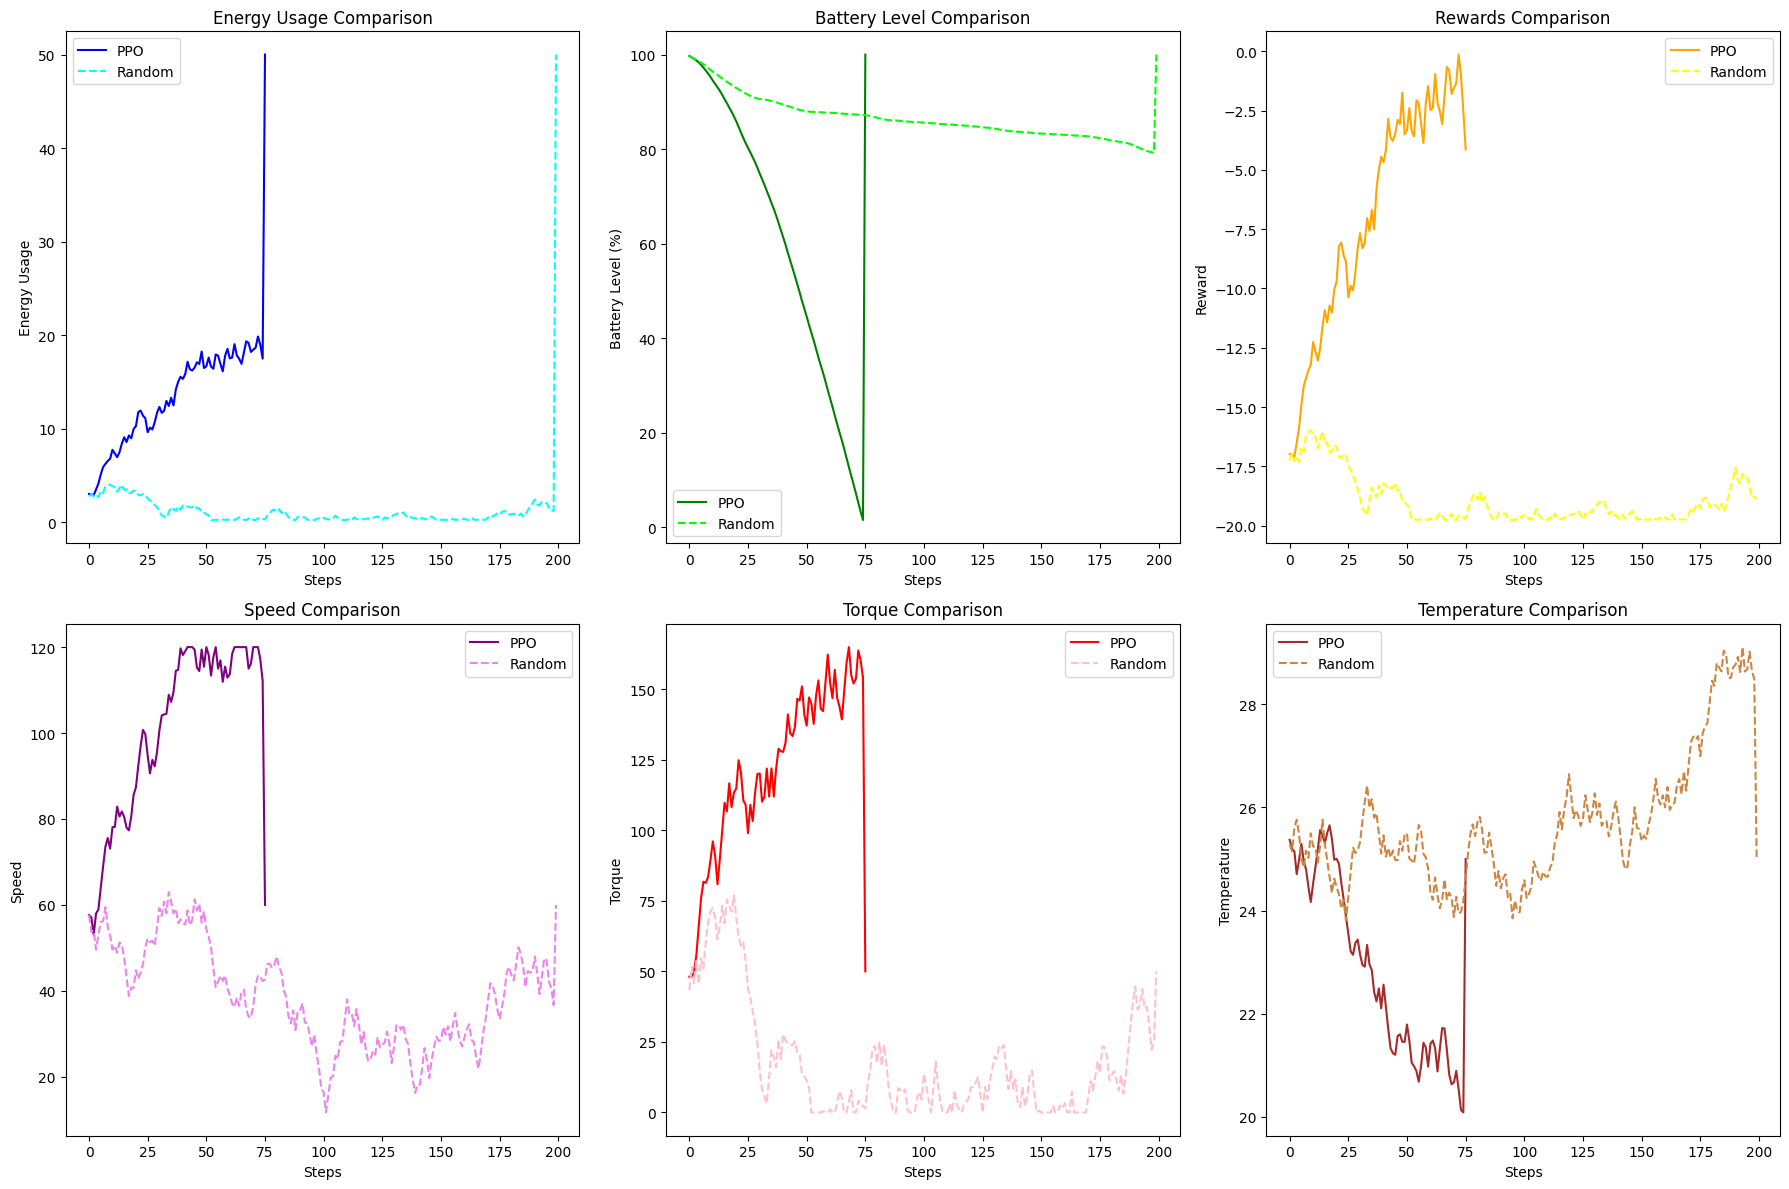


Summary of Results:
PPO - Final Battery Level: 100.0, Cumulative Reward: [-519.59125]
Random - Final Battery Level: 100.0, Cumulative Reward: [-3791.0562]


In [22]:
# Function to simulate a random policy (untrained model)
def simulate_random_policy(env, steps=200):
    state = env.reset()
    energy_levels = []
    battery_levels = []
    rewards = []
    speeds = []
    torques = []
    temperatures = []
    log_data = []

    for step in range(steps):
        # Generate random actions and reshape for batched environments
        action = env.action_space.sample()
        action = np.expand_dims(action, axis=0)  # Reshape for DummyVecEnv compatibility
        state, reward, done, _ = env.step(action)

        # Collect metrics for plotting
        energy_levels.append(state[0][0])    # Energy level
        battery_levels.append(state[0][4])  # Battery level
        rewards.append(reward)              # Reward
        speeds.append(state[0][1])          # Speed
        torques.append(state[0][2])         # Torque
        temperatures.append(state[0][3])    # Temperature

        # Log data for this step
        log_data.append({
            "Step": step + 1,
            "Energy": state[0][0],
            "Battery": state[0][4],
            "Speed": state[0][1],
            "Torque": state[0][2],
            "Temperature": state[0][3],
            "Reward": reward
        })

        if done:
            break

    return energy_levels, battery_levels, rewards, speeds, torques, temperatures, log_data


# Simulate the PPO-trained model
energy_levels_ppo, battery_levels_ppo, rewards_ppo, speeds_ppo, torques_ppo, temperatures_ppo, log_ppo = simulate_motor_optimization_with_logs(model, env)

# Simulate the random policy
energy_levels_random, battery_levels_random, rewards_random, speeds_random, torques_random, temperatures_random, log_random = simulate_random_policy(env)

# Visualization for Comparison
plt.figure(figsize=(18, 12))

# Energy Levels Comparison
plt.subplot(2, 3, 1)
plt.plot(energy_levels_ppo, label="PPO", color="blue")
plt.plot(energy_levels_random, label="Random", color="cyan", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Energy Usage")
plt.title("Energy Usage Comparison")
plt.legend()

# Battery Levels Comparison
plt.subplot(2, 3, 2)
plt.plot(battery_levels_ppo, label="PPO", color="green")
plt.plot(battery_levels_random, label="Random", color="lime", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Battery Level (%)")
plt.title("Battery Level Comparison")
plt.legend()

# Rewards Comparison
plt.subplot(2, 3, 3)
plt.plot(rewards_ppo, label="PPO", color="orange")
plt.plot(rewards_random, label="Random", color="yellow", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Rewards Comparison")
plt.legend()

# Speeds Comparison
plt.subplot(2, 3, 4)
plt.plot(speeds_ppo, label="PPO", color="purple")
plt.plot(speeds_random, label="Random", color="violet", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Speed")
plt.title("Speed Comparison")
plt.legend()

# Torques Comparison
plt.subplot(2, 3, 5)
plt.plot(torques_ppo, label="PPO", color="red")
plt.plot(torques_random, label="Random", color="pink", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Torque")
plt.title("Torque Comparison")
plt.legend()

# Temperatures Comparison
plt.subplot(2, 3, 6)
plt.plot(temperatures_ppo, label="PPO", color="brown")
plt.plot(temperatures_random, label="Random", color="peru", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Temperature")
plt.title("Temperature Comparison")
plt.legend()

plt.tight_layout()
plt.show()

# Print Summary of Results
print("\nSummary of Results:")
print(f"PPO - Final Battery Level: {battery_levels_ppo[-1]}, Cumulative Reward: {sum(rewards_ppo)}")
print(f"Random - Final Battery Level: {battery_levels_random[-1]}, Cumulative Reward: {sum(rewards_random)}")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1168 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 864          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0071368003 |
|    clip_fraction        | 0.074        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.00428      |
|    learning_rate        | 0.0003       |
|    loss                 | 2.97e+04     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00832     |
|    std                  | 0.986        |
|    value_loss           | 5.92e+04     |

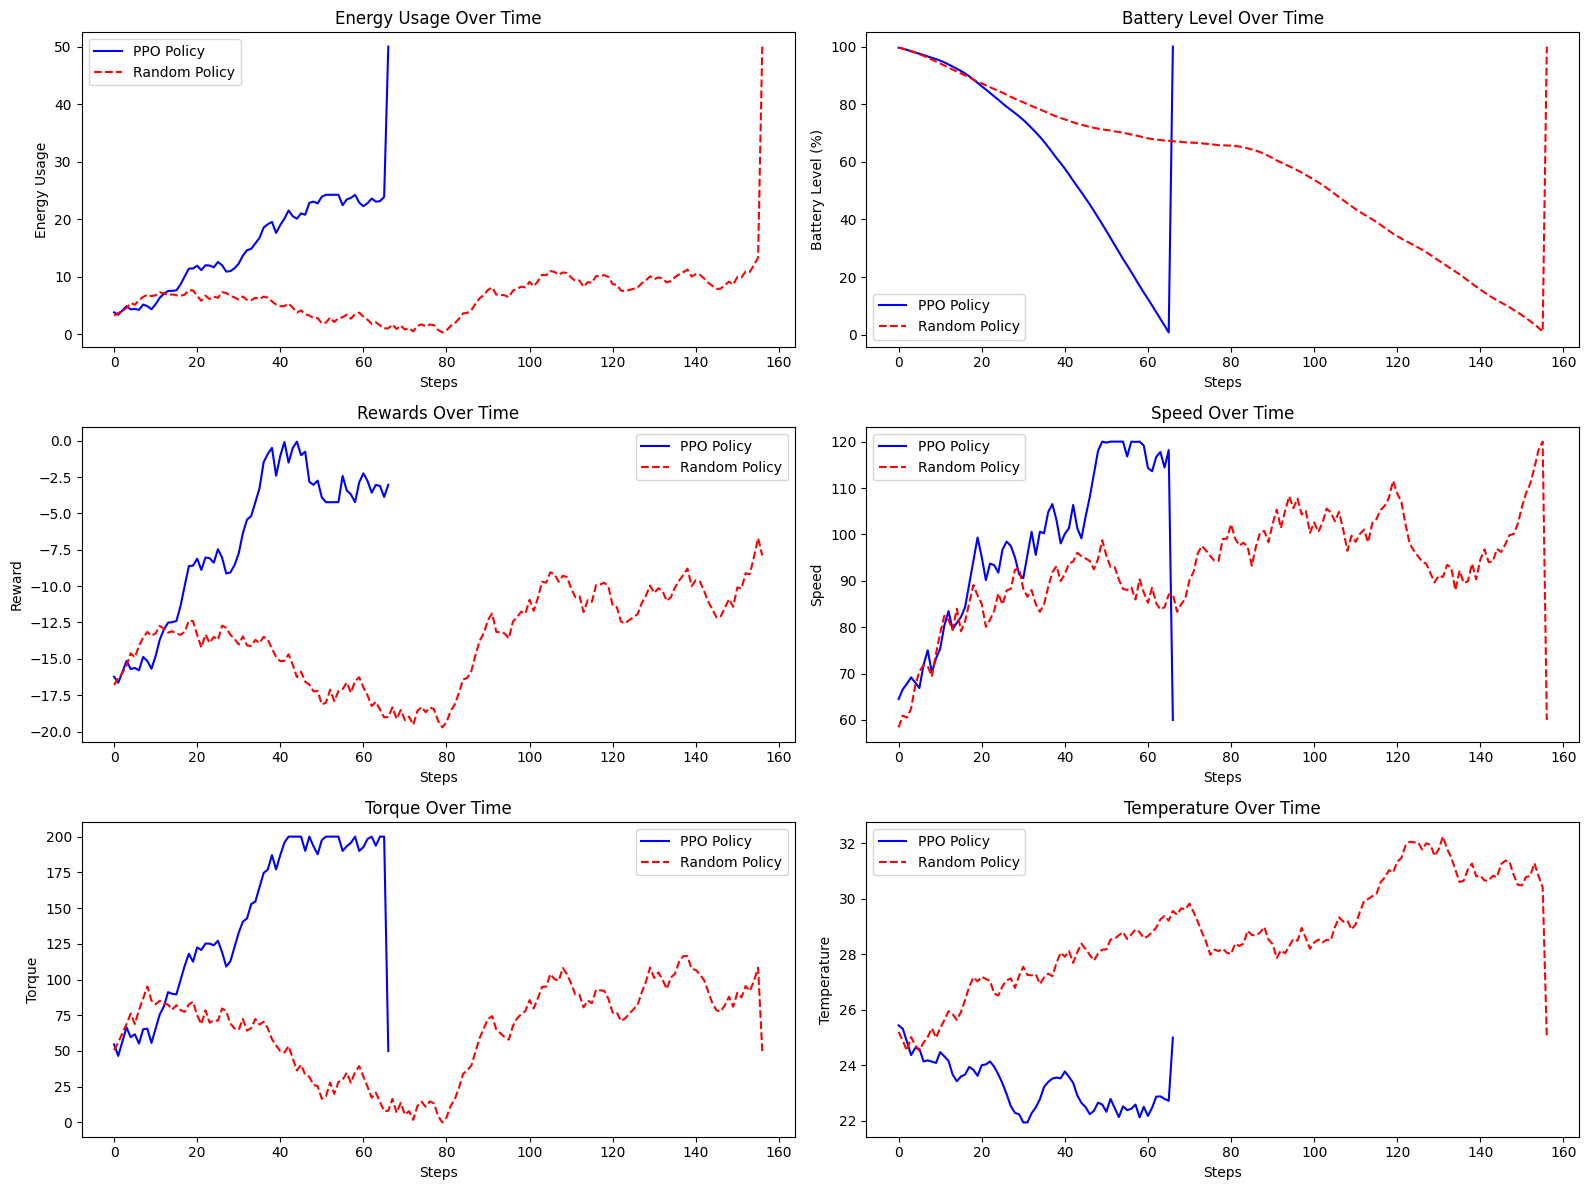

In [23]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Custom Environment for Motor Optimization
class MotorOptimizationEnvWithBattery(gym.Env):
    def __init__(self):
        super(MotorOptimizationEnvWithBattery, self).__init__()

        # Action space: Adjust torque and speed
        self.action_space = gym.spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)

        # Observation space: [energy usage, speed, torque, temperature, battery level]
        self.observation_space = gym.spaces.Box(
            low=np.array([0, 0, 0, 0, 0]),  # Minimum values
            high=np.array([100, 120, 200, 100, 100]),  # Maximum values
            dtype=np.float32,
        )

        # Initial state
        self.state = np.array([50.0, 60.0, 50.0, 25.0, 100.0])  # [energy, speed, torque, temperature, battery level]
        self.steps = 0
        self.max_steps = 200

    def reset(self):
        """Reset the environment."""
        self.state = np.array([50.0, 60.0, 50.0, 25.0, 100.0])  # Reset battery to full
        self.steps = 0
        return self.state

    def step(self, action):
        """Simulate a step in the environment."""
        self.steps += 1

        # Unpack state variables
        energy, speed, torque, temperature, battery = self.state

        # Adjust speed and torque based on actions
        speed += action[0] * 5  # Adjust speed
        torque += action[1] * 10  # Adjust torque

        # Clip speed and torque to their valid ranges
        speed = np.clip(speed, 0, 120)
        torque = np.clip(torque, 0, 200)

        # Calculate energy consumption based on speed and torque
        energy_consumption = (speed * torque / 1000) + (temperature / 100)
        energy = np.clip(energy_consumption, 0, 100)  # Update energy readings

        # Update battery level (battery decreases based on energy consumption)
        battery -= energy_consumption * 0.1  # Battery usage factor
        battery = np.clip(battery, 0, 100)  # Ensure battery doesn't go below 0

        # Calculate reward
        optimal_consumption = 20  # Define an optimal energy consumption threshold
        efficiency_penalty = abs(energy_consumption - optimal_consumption)  # Penalize deviations
        reward = -efficiency_penalty

        # Update state
        temperature += np.random.uniform(-0.5, 0.5)  # Simulate temperature fluctuation
        self.state = np.array([energy, speed, torque, temperature, battery])

        # Check if the episode is done
        done = self.steps >= self.max_steps or battery <= 0

        return self.state, reward, done, {}

    def render(self, mode="human"):
        """Render the environment."""
        print(f"State: {self.state}")

# Create and wrap the environment
env = DummyVecEnv([lambda: MotorOptimizationEnvWithBattery()])

# Initialize PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the PPO model
model.learn(total_timesteps=10000)

# Function to simulate a policy (PPO or random)
def simulate_policy(env, model=None, steps=200, random_policy=False):
    state = env.reset()
    energy_levels = []
    battery_levels = []
    rewards = []
    speeds = []
    torques = []
    temperatures = []
    log_data = []

    for step in range(steps):
        # Choose action based on policy
        if random_policy:
            action = env.action_space.sample()
            action = np.expand_dims(action, axis=0)  # Reshape for DummyVecEnv compatibility
        else:
            action, _ = model.predict(state)

        state, reward, done, _ = env.step(action)

        # Collect metrics for plotting
        energy_levels.append(state[0][0])    # Energy level
        battery_levels.append(state[0][4])  # Battery level
        rewards.append(reward)              # Reward
        speeds.append(state[0][1])          # Speed
        torques.append(state[0][2])         # Torque
        temperatures.append(state[0][3])    # Temperature

        # Log data for this step
        log_data.append({
            "Step": step + 1,
            "Energy": state[0][0],
            "Battery": state[0][4],
            "Speed": state[0][1],
            "Torque": state[0][2],
            "Temperature": state[0][3],
            "Reward": reward
        })

        if done:
            break

    return energy_levels, battery_levels, rewards, speeds, torques, temperatures, log_data

# Simulate the trained PPO model
energy_levels_ppo, battery_levels_ppo, rewards_ppo, speeds_ppo, torques_ppo, temperatures_ppo, log_ppo = simulate_policy(env, model)

# Simulate the random policy
energy_levels_random, battery_levels_random, rewards_random, speeds_random, torques_random, temperatures_random, log_random = simulate_policy(env, random_policy=True)

# Visualization for Comparison
plt.figure(figsize=(16, 12))

# Energy Levels
plt.subplot(3, 2, 1)
plt.plot(energy_levels_ppo, label="PPO Policy", color="blue")
plt.plot(energy_levels_random, label="Random Policy", color="red", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Energy Usage")
plt.title("Energy Usage Over Time")
plt.legend()

# Battery Levels
plt.subplot(3, 2, 2)
plt.plot(battery_levels_ppo, label="PPO Policy", color="blue")
plt.plot(battery_levels_random, label="Random Policy", color="red", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Battery Level (%)")
plt.title("Battery Level Over Time")
plt.legend()

# Rewards
plt.subplot(3, 2, 3)
plt.plot(rewards_ppo, label="PPO Policy", color="blue")
plt.plot(rewards_random, label="Random Policy", color="red", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Rewards Over Time")
plt.legend()

# Speeds
plt.subplot(3, 2, 4)
plt.plot(speeds_ppo, label="PPO Policy", color="blue")
plt.plot(speeds_random, label="Random Policy", color="red", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Speed")
plt.title("Speed Over Time")
plt.legend()

# Torques
plt.subplot(3, 2, 5)
plt.plot(torques_ppo, label="PPO Policy", color="blue")
plt.plot(torques_random, label="Random Policy", color="red", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Torque")
plt.title("Torque Over Time")
plt.legend()

# Temperatures
plt.subplot(3, 2, 6)
plt.plot(temperatures_ppo, label="PPO Policy", color="blue")
plt.plot(temperatures_random, label="Random Policy", color="red", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Temperature")
plt.title("Temperature Over Time")
plt.legend()

plt.tight_layout()
plt.show()
